# Chart-Book-Neutron-Density-Porosity-using-KNN

The objective of this project is to calculate a Neutron vs. Bulk Density Cross-Plot Total porosity using, the Schlumberger CNL or TNPH Charts as shown below. It is important to use the proper Neutron log associated with the appropriate chart for either fresh or saline fluid densities as specified. The Neutron logs should also be on a limestone matrix with these charts. 

![CNL_Image](CNL.png)

![TNPH_Image](TNPH.png)

This program uses as training data a matrix of Neutron Porosity (V/V) vs. Bulk Density (G/CC) with known porosities (see below). In this example we are using test data as our log data to observe how well the program is actually working. We have very good agreement between our log analysis chart book training values and the values estimated from this program. 

The porosity estimations are made using KNN. Before we begin any distance calculations, we first normalize the Neutron porosity and Bulk Density curves and then use a KNN of 3 to estimate our Cross-Plot porosity values from our test data set.   

![SMatrixCNL_Image](Matrix_CNL2.png)


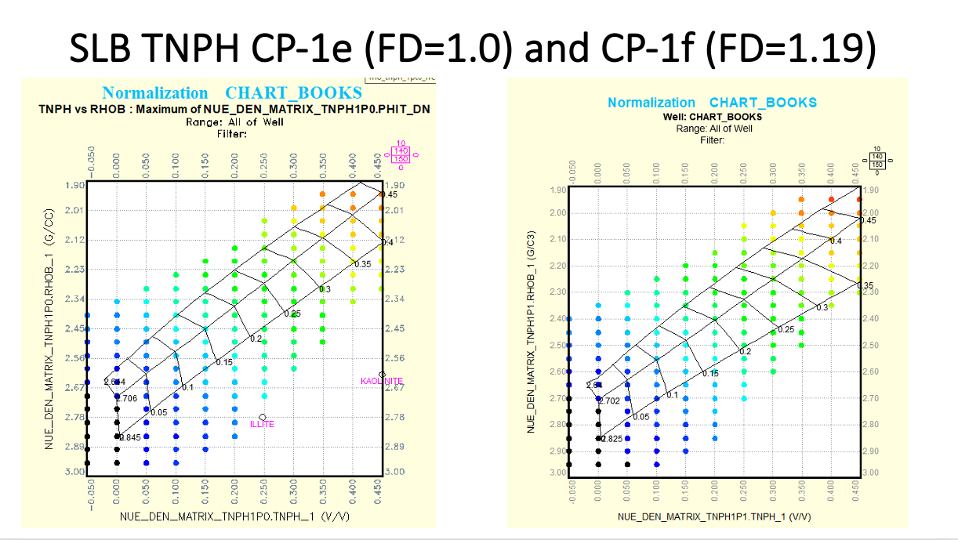

This program has been tested for the charts available showing good agreement with the training data for our calculated porosities. Further testing is recommended before using this program to better understand the uncertainties in the estimations and validate using a KNN of 3. Please provide feedback if you have any issues.

We are using CNL_1pt1_testdata.xlsx or TNPH_1pt19_testdata.xlsx to be used as log data for testing purposes, but you could use your own log data in lieu of this file to calculate Neutron-Density Total Cross-Plot porosities for your analysis.

We have a set of 4 Schlumberger Chart Book data files representing 4 of the Schlumberger Neutron-Density charts; 2 fluid densities for CNL and 2 for TNPH. Other vendor charts will also be included as needed in the future. 

# Code:

### Load dependencies

In [1]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a script file.
"""
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



Bad key "text.kerning_factor" on line 4 in
/Users/craig/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Read In Digitized Chartbook Data using the appropriate chart:

In [2]:
"""
# =============================================================================
# # ======================================================================= # #
# # # 
# # #      Read in Digitized Chartbook data stored in Excel spreadsheet   # # #
# # #
# # ======================================================================= # #
# =============================================================================
"""


#select the proper Neutron-Denisity Chartbook file
''' 
    Schlumberger CNL Neutron Log at different Fluid Densities
'''
#file = r'./data/CNL_1pt0.xlsx'
#file = r'./data/CNL_1pt1.xlsx'
''' 
    Schlumberger TNPH Neutron Log at different Fluid Densities
'''
#file = r'./data/TNPH_1pt0.xlsx'
file = r'./data/TNPH_1pt19.xlsx'



df_chart = pd.read_excel(file,index_col=False)
df_chart.head()


CNL_chart  = df_chart['Neutron']
RHOB_chart = df_chart['RHOB']
Rho_Matrix_chart  = df_chart['Rho_Matrix']
Porosity_chart = df_chart['Porosity']     


#Fluid Density
FD = 1.1

### Chart Book Data with Porosity on Color axis:

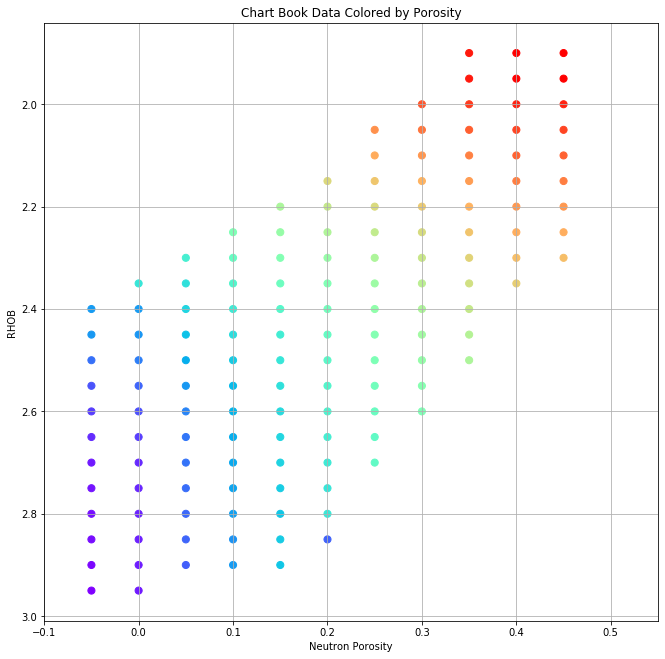

In [3]:
plt.figure(figsize=(11,11))    
#plt.scatter(CNL_chart, RHOB_chart, c=Porosity_chart,cmap="RdYlGn",)
#plt.scatter(CNL_chart, RHOB_chart, s=50, c=Porosity_chart)
#plt.scatter(CNL_chart, RHOB_chart, c=Porosity_chart,cmap="RdYlGn")
plt.scatter(CNL_chart, RHOB_chart, s=50, c = Porosity_chart, cmap = "rainbow")
plt.xlim(-0.1, 0.55)
plt.gca().invert_yaxis()
plt.title("Chart Book Data Colored by Porosity")
plt.ylabel('RHOB')
plt.xlabel('Neutron Porosity')
plt.grid(True)
plt.show()

### Chart Book Data with Rho Matrix on Color axis:

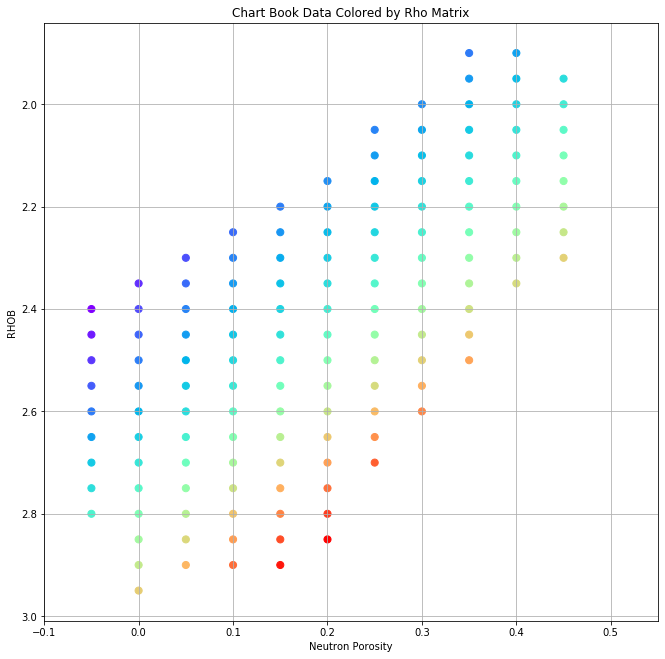

In [4]:
plt.figure(figsize=(11,11))    
#plt.scatter(CNL_chart, RHOB_chart, c=Porosity_chart,cmap="RdYlGn",)
#plt.scatter(CNL_chart, RHOB_chart, s=50, c=Porosity_chart)
#plt.scatter(CNL_chart, RHOB_chart, c=Porosity_chart,cmap="RdYlGn")
plt.scatter(CNL_chart, RHOB_chart, s=50, c = Rho_Matrix_chart, cmap = "rainbow")
plt.xlim(-0.1, 0.55)
plt.gca().invert_yaxis()
plt.title("Chart Book Data Colored by Rho Matrix")
plt.ylabel('RHOB')
plt.xlabel('Neutron Porosity')
plt.grid(True)
plt.show()

## Read In log data. This can be test data that is used to QC the results:

You will need to ensure that the df_log['xxx'] matches what is in the log file

In [5]:
"""
# =============================================================================
# # ===========================================================================
# # #           
# # #            Read in log data file as a Excel Spreadsheet
# # #                   
# # ===========================================================================
# =============================================================================
"""
file = r'./data/TNPH_1pt19_testdata.xlsx'
#file = r'./data/CNL_1pt1_testdata.xlsx'
#file = r'./data/log_data_co3.xlsx'


df_log = pd.read_excel(file,index_col=False)
df_log.head()

Dep  = df_log['DEPTH']


'''
    Name of Neutron Log in log file
'''
CNL = df_log['TNPH']    
#CNL  = df_log['CNL']
#CNL  = df_log['NPHI']



RHOB = df_log['RHOB']
RHOMAA = df_log['Rho_Matrix']
Porosity = df_log['Porosity']

## KNN to estimate Cross Plot porosity from the appropriate chart:

In [6]:
"""
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# ##
# ##            This is the beginnin of KNN estimating ND xplt Porosity 
# ##
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================
"""  
deptharray = []
porarray   = []; #make list of 0 length
RHOMAA_array = []
Porosity_array = []
rhoarray = []

#log Data
for k in range(0,len(df_log) ,1):  

        cnl = (CNL[k]-(-0.05))/(0.6-(-0.05))
        rhob = (RHOB[k]-1.9)/(3-1.9)
        


        dist_inv    = []
        dist_cnl    = []
        dist_rhob    = []
        inv_dist_array = []
        Por_weight = []
        CNL_norm = []
        RHOB_norm = []

        dist_inv_total = 0
        Por_total     = 0


        #this is the chartbook_reference_data being used 
        for i in range(0,len(df_chart),1):
        
                CNL_norm.append((CNL_chart[i] - (-0.05)) / (0.6 - (-0.05)))
                RHOB_norm.append((RHOB_chart[i] - 1.9) / (3.0 - 1.9))
                
                #Euclidian Distance
                dist_cnl.append((abs(cnl - CNL_norm[i])))
                dist_rhob.append( abs(rhob - RHOB_norm[i]))

                if math.sqrt(dist_cnl[i]**2 + dist_rhob[i]**2) > 0:
                    dist_inv.append( 1  /  math.sqrt( dist_cnl[i]**2 + dist_rhob[i]**2)  )
                else:
                    dist_inv.append( 1  /  math.sqrt( 0.0001 + dist_cnl[i]**2 + dist_rhob[i]**2)  )
        
                
                #calculalte weights
                Por_weight.append(dist_inv[i]  * Porosity_chart[i])
                
        
                inv_dist_array.append(dist_inv[i]);  # add items
        
        # =============================================================================
        ###                    KNN Array
        # # ===========================================================================
        # # #--------------------------------------------------------------------------
                distance_knn_array = [dist_inv, Por_weight]
        #        distance_knn_array = [Permeability, Porosity, G1, PD1, BV1, G2, PD2, BV2]
        # # #--------------------------------------------------------------------------
        # # ===========================================================================
        # =============================================================================
        xnorm=np.array(CNL_norm)
        ynorm=np.array(RHOB_norm)
        
            
        #knn_array = np.transpose array
        knn_array = np.transpose(distance_knn_array)
        #print(knn_array)
        
        #Sort array from large to low by column 0 which is dist_inv 
        #xknn=np.array(knn_array)
        
        #matsor x[x[:,column].argsort()[::-1]] and -1 us reverse order
        mat_sort = knn_array[knn_array[:,0].argsort()[::-1]] #firt column reverse sort (-1)
        #mat_sort = x[x[:,1].argsort()[::-1]]
        #mat_sort = x[x[:,2].argsort()[::-1]]
        
         
        #------------------------------------------------------------------------------
        #    Number of nearest Neighbors
        #------------------------------------------------------------------------------
        n_neighbors = 3
        #------------------------------------------------------------------------------
        
        dist_inv_total_knn = 0
        por_total_knn = 0
        
        
        
        
        #kNN Estimates for first 3 rows
        #dist_inv_total = mat_sort[0][0] + mat_sort[1][0] + mat_sort[2][0]
        for i in range(0,n_neighbors,1):
            dist_inv_total_knn = dist_inv_total_knn + mat_sort[i][0]
            por_total_knn  = por_total_knn + mat_sort[i][1]
        
        
        #back to k values and calculate estimations now
        por_est_knn  = por_total_knn  / dist_inv_total_knn
        
        
#        print()
#        print(Fore.GREEN +'Estimated Porosity from KNN =',n_neighbors,' on normlalized log data')
#        print(Fore.GREEN + '     Por =',por_est_knn, ) 
#
        phixnd_chartbook = por_est_knn
        rhomatrix = (RHOB[k]-phixnd_chartbook*FD)/(1-phixnd_chartbook)


#------------------------------------------------------------------------------ 
#            Write Data to arrays
#------------------------------------------------------------------------------
        deptharray.append(Dep[k]); #add items 
        porarray.append(phixnd_chartbook); #add items 
        rhoarray.append(rhomatrix); #add items
        RHOMAA_array.append(RHOMAA[k]);
        Porosity_array.append(Porosity[k]);



## Make a few Depth Plots for QC purposes:

144 144 144


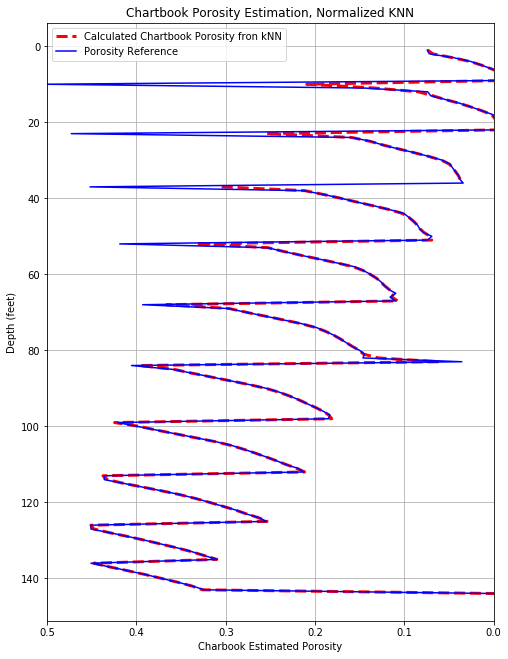

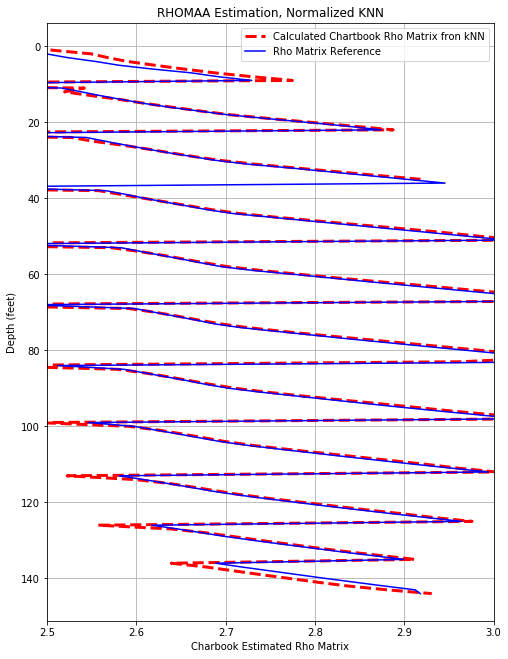

In [7]:
x=np.array(porarray)
y=np.array(deptharray)
xx=np.array(Porosity_array)
xxx=rhoarray
xxxx = RHOMAA_array 

#print(Porosity_array)
print(len(x),len(xx),len(y))

plt.figure(figsize=(8,11))    
plt.plot(x, y,'--r',lw=3, label= 'Calculated Chartbook Porosity fron kNN')
plt.plot(xx, y,'-b', label= 'Porosity Reference')
plt.xlim(0.5, 0)
plt.legend()
plt.gca().invert_yaxis()

plt.title("Chartbook Porosity Estimation, Normalized KNN")
plt.ylabel('Depth (feet)')
plt.xlabel('Charbook Estimated Porosity')
plt.grid(True)


plt.show()


plt.figure(figsize=(8,11))    
plt.plot(xxx, y,'--r',lw=3, label= 'Calculated Chartbook Rho Matrix fron kNN')
plt.plot(xxxx, y,'-b', label= 'Rho Matrix Reference')
plt.xlim(2.5, 3)
plt.gca().invert_yaxis()
plt.legend()

plt.title("RHOMAA Estimation, Normalized KNN")
plt.ylabel('Depth (feet)')
plt.xlabel('Charbook Estimated Rho Matrix')
plt.grid(True)

plt.show()
